In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

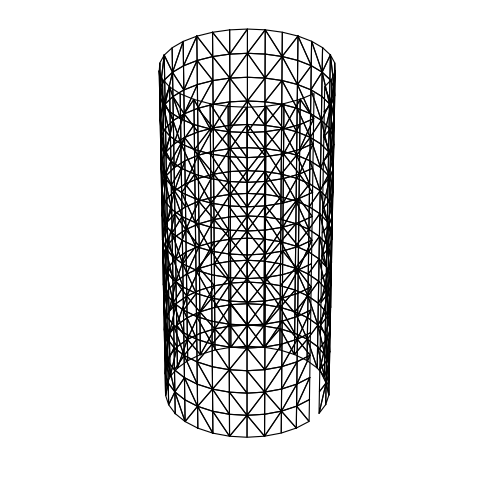

In [5]:
# ==== Paso 1: Puntos en coordenadas paramétricas ====
n_theta = 30  # puntos en dirección circunferencia
n_z = 15      # puntos en altura
theta = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
z = np.linspace(-1, 1, n_z)
Theta, Z = np.meshgrid(theta, z)

# Convertir a lista de puntos
points_param = np.column_stack((Theta.ravel(), Z.ravel()))

# ==== Paso 2: Triangulación Delaunay en 2D ====
tri = Delaunay(points_param)

# ==== Paso 3: Mapeo a coordenadas 3D ====
R = 1
X = R * np.cos(points_param[:,0])
Y = R * np.sin(points_param[:,0])
XYZ = np.column_stack((X, Y, points_param[:,1]))

# ==== Paso 4: Graficar el mallado T3 ====
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for simplex in tri.simplices:
    pts = XYZ[simplex]
    ax.plot(*zip(*np.vstack((pts, pts[0]))), color='k', linewidth=0.8)

ax.set_box_aspect([1,1,2])  # relación de aspecto
ax.set_axis_off()
plt.show()


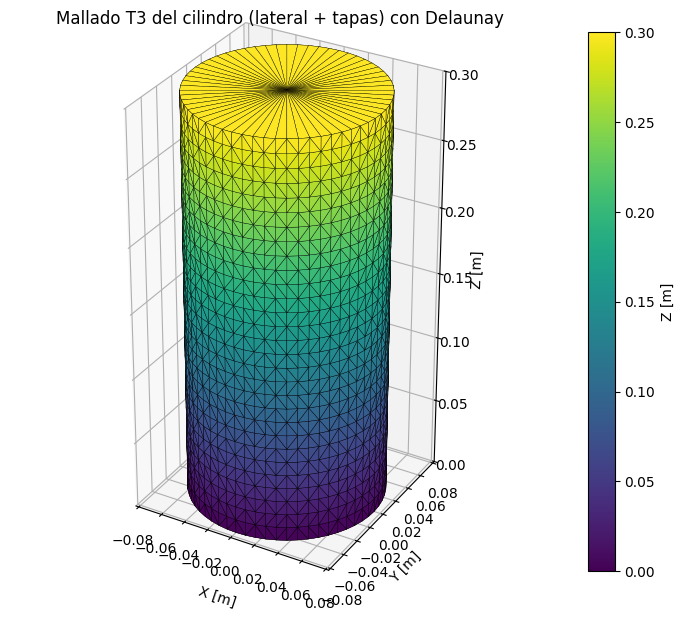

Nodos: 1922, Elementos T3: 3600
Exportados: nodes.txt, elems.txt


In [ ]:
# ---------- Parámetros geométricos (ejemplo: probeta 150x300 mm) ----------
diam = 0.15   # m
height = 0.30 # m
R = diam / 2

# malla paramétrica
n_theta = 60   # resolución circumferencial (más = más fino)
n_z = 30       # resolución en altura

# incluimos el endpoint en theta para permitir triángulos que crucen la costura,
# luego fusionaremos los nodos duplicados (theta=0 y theta=2pi)
theta = np.linspace(0.0, 2*np.pi, n_theta+1, endpoint=True)
z = np.linspace(0.0, height, n_z)
Theta, Z = np.meshgrid(theta, z)
points_param = np.column_stack((Theta.ravel(), Z.ravel()))
n_param = points_param.shape[0]

# Triangulación Delaunay en el rectángulo (theta, z)
tri = Delaunay(points_param)

# ---- Fusionar nodos en la costura theta=2pi -> theta=0
# índices de la primera y última columna en la grilla paramétrica
n_cols = n_theta + 1
n_rows = n_z
# índice (fila, col) -> linear index: i = row * n_cols + col
first_col_idx = np.arange(0, n_rows * n_cols, n_cols)          # col=0
last_col_idx  = np.arange(n_cols - 1, n_rows * n_cols, n_cols) # col=n_cols-1

# mapping: si un vértice apunta a un nodo de la última columna, reemplazar por el correspondiente de la primera columna
index_map = np.arange(n_param)  # por defecto identidad
index_map[last_col_idx] = first_col_idx

# aplicar el mapa a los triángulos y eliminar triángulos degenerados (con vértices repetidos)
simplices_mapped = np.array([[index_map[idx] for idx in tri_simp] for tri_simp in tri.simplices])
# eliminar triángulos con indices repetidos
valid = np.all([
    simplices_mapped[:,0] != simplices_mapped[:,1],
    simplices_mapped[:,1] != simplices_mapped[:,2],
    simplices_mapped[:,2] != simplices_mapped[:,0]
], axis=0)
simplices = simplices_mapped[valid]

# ---- Construir lista de nodos 3D únicos (fusionando duplicados)
# creamos un set de nodos usados por simplices y recomprimimos índices
used_nodes = np.unique(simplices.ravel())
old_to_new = -np.ones(n_param, dtype=int)
old_to_new[used_nodes] = np.arange(used_nodes.size)

# obtener coordenadas paramétricas únicas y después mapear a 3D
points_param_used = points_param[used_nodes]
theta_used = points_param_used[:,0] % (2*np.pi)  # asegurar intervalo [0,2pi)
z_used = points_param_used[:,1]

X = R * np.cos(theta_used)
Y = R * np.sin(theta_used)
Z3 = z_used
nodes_xyz = np.column_stack((X, Y, Z3))

# elementos T3 con índices renumerados (0..N-1)
elems = old_to_new[simplices]

# ---- Añadir tapas: triangulación del disco superior e inferior
# función auxiliar para triangular un disco periférico usando Delaunay en xy
def triangulate_disk(z_level):
    th = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
    perim_xy = np.column_stack((R*np.cos(th), R*np.sin(th)))
    center_xy = np.array([[0.0, 0.0]])
    pts2 = np.vstack((center_xy, perim_xy))  # primero centro, luego periferia
    tri_disk = Delaunay(pts2[:, :2])
    faces = []
    for s in tri_disk.simplices:
        # cada s es índices en pts2; convertir a 3D (x,y,z_level)
        pts3 = np.column_stack((pts2[s,0], pts2[s,1], np.full(3, z_level)))
        faces.append(pts3)
    return pts2, tri_disk.simplices

# tapa superior (z = height)
pts_top2, simplices_top = triangulate_disk(height)
# tapa inferior (z = 0)
pts_bot2, simplices_bot = triangulate_disk(0.0)

# Para integrar tapas a la lista global de nodos/elementos, añadimos los puntos (centro+perimetro)
# primero preparar funciones para insertar y crear elementos T3
def append_nodes_and_elems(pts2, z_level, nodes_xyz, elems):
    # pts2: (Npi x 2) array (center + perimeter)
    new_nodes = np.column_stack((pts2[:,0], pts2[:,1], np.full(pts2.shape[0], z_level)))
    start_idx = nodes_xyz.shape[0]
    nodes_xyz = np.vstack((nodes_xyz, new_nodes))
    # elementos: tri simplices referencian indices en pts2; convertir a indices globales
    local_to_global = np.arange(start_idx, start_idx + pts2.shape[0])
    new_elems = []
    for s in Delaunay(pts2[:, :2]).simplices:
        new_elems.append(local_to_global[s])
    elems = np.vstack((elems, np.array(new_elems, dtype=int))) if elems.size else np.array(new_elems, dtype=int)
    return nodes_xyz, elems

# Append tapas (usamos triangulación recién calculada para consistencia)
# Tapa superior
start_top = nodes_xyz.shape[0]
nodes_top = np.column_stack((pts_top2[:,0], pts_top2[:,1], np.full(pts_top2.shape[0], height)))
nodes_xyz = np.vstack((nodes_xyz, nodes_top))
top_local_idxs = np.arange(start_top, start_top + pts_top2.shape[0])
top_elems = np.array([top_local_idxs[s] for s in simplices_top], dtype=int)
# Tapa inferior
start_bot = nodes_xyz.shape[0]
nodes_bot = np.column_stack((pts_bot2[:,0], pts_bot2[:,1], np.zeros(pts_bot2.shape[0])))
nodes_xyz = np.vstack((nodes_xyz, nodes_bot))
bot_local_idxs = np.arange(start_bot, start_bot + pts_bot2.shape[0])
bot_elems = np.array([bot_local_idxs[s] for s in simplices_bot], dtype=int)

# Combinar elementos: elems (lateral) + top_elems + bot_elems
if elems.size == 0:
    elems = np.empty((0,3), dtype=int)
elems = np.vstack((elems, top_elems, bot_elems))

# ---- Visualización: convertir elems (índices) en caras (coordenadas) y colorear por Z promedio
faces = [nodes_xyz[e] for e in elems]
z_values_elem = np.array([face[:,2].mean() for face in faces])
norm = plt.Normalize(z_values_elem.min(), z_values_elem.max())
cmap = plt.cm.viridis
face_colors = cmap(norm(z_values_elem))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
mesh = Poly3DCollection(faces, facecolors=face_colors, edgecolors='k', linewidths=0.25)
ax.add_collection3d(mesh)

ax.set_xlim(-R*1.1, R*1.1)
ax.set_ylim(-R*1.1, R*1.1)
ax.set_zlim(0, height)
ax.set_box_aspect([1,1,height/diam])
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
plt.title('Mallado T3 del cilindro (lateral + tapas) con Delaunay')
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(z_values_elem)
fig.colorbar(mappable, ax=ax, label='Z [m]')
plt.tight_layout()
plt.show()

# # ---- Exportar nodos y elementos a texto simple (nodos.txt y elems.txt)
# np.savetxt('nodes.txt', nodes_xyz, header='x y z', comments='')
# np.savetxt('elems.txt', elems, fmt='%d', header='n1 n2 n3 (0-based indexing)', comments='')

# print(f"Nodos: {nodes_xyz.shape[0]}, Elementos T3: {elems.shape[0]}")
# print("Exportados: nodes.txt, elems.txt")


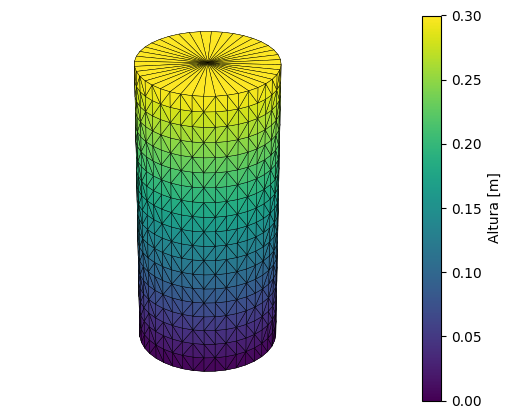

In [7]:
# Parámetros de la probeta
diam, height = 0.15, 0.30
R = diam / 2
n_theta, n_z = 40, 20

# Mallado paramétrico (theta,z)
theta = np.linspace(0, 2*np.pi, n_theta+1)
z = np.linspace(0, height, n_z)
Theta, Z = np.meshgrid(theta, z)
pts2D = np.column_stack((Theta.ravel(), Z.ravel()))

# Delaunay lateral y cierre costura
tri = Delaunay(pts2D)
idx_map = np.arange(pts2D.shape[0])
for i in range(n_z):
    idx_map[i*(n_theta+1) + n_theta] = i*(n_theta+1)
simplices = np.array([[idx_map[k] for k in t] for t in tri.simplices])
simplices = simplices[~(simplices[:,0]==simplices[:,1])]

# Nodos 3D únicos
used = np.unique(simplices)
map_new = -np.ones(len(idx_map),int); map_new[used] = np.arange(len(used))
simplices = map_new[simplices]
theta_u, z_u = pts2D[used,0]%(2*np.pi), pts2D[used,1]
nodes = np.c_[R*np.cos(theta_u), R*np.sin(theta_u), z_u]

# Tapas (discos triangulados)
def disk(zl):
    th = np.linspace(0,2*np.pi,n_theta,endpoint=False)
    p = np.c_[R*np.cos(th), R*np.sin(th), np.full(n_theta,zl)]
    c = np.array([[0,0,zl]])
    pts = np.vstack((c,p))
    tri_d = Delaunay(pts[:,:2])
    return np.vstack((nodes,pts)), tri_d.simplices + len(nodes)

nodes, top_s = disk(height)
nodes, bot_s = disk(0.0)
elems = np.vstack((simplices, top_s, bot_s))

# Graficar con cmap según z
faces = [nodes[e] for e in elems]
z_mean = [f[:,2].mean() for f in faces]
norm, cmap = plt.Normalize(min(z_mean), max(z_mean)), plt.cm.viridis
fc = [cmap(norm(v)) for v in z_mean]

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.add_collection3d(Poly3DCollection(faces, facecolors=fc, edgecolors='k', lw=0.3))
ax.set_box_aspect([1,1,height/diam]); ax.axis('off')
plt.colorbar(plt.cm.ScalarMappable(norm=norm,cmap=cmap), ax=ax, label='Altura [m]')
plt.show()
